# Parâmetros Gerais para realização do Experimento

In [ ]:
numKfolds = 5

perc_da_base_usar = 100
nclasses = 3
listLearnRates_trnf_FT = [2.5e-5, 5e-5]
listDropOuts_trnf_FT = [0, 0.10]
nepochsFT_trnf_FT = 1
early_stop_trnf_FT = 2
batch_size_trnf_FT = 16
batch_status_trnf_FT = 16
max_length_trnf_FT = 128

trf_escolhido = 'melll-uff/bertweetbr' 
# trf_escolhido = 'vinai/bertweet-base' #en bertweet
# trf_escolhido = 'roberta-base' #en roberta
# trf_escolhido = 'bert-base-multilingual-cased' #pt m-bert
# trf_escolhido = 'xlm-roberta-base' #pt xml-roberta

lg_trf = 'pt'

idGPU = 1


# Importando bibliotecas para uso com Python

In [2]:
!pip install transformers
!pip install accelerate
!pip install bertopic
!pip install wordcloud
!pip install unidecode

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import os
import gc
import copy

import re
import string

import numpy as np
import pandas as pd
from math import ceil

import matplotlib.pyplot as plt

from unidecode import unidecode

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

from accelerate import Accelerator



In [4]:
device = torch.device('cuda:'+str(idGPU) if torch.cuda.is_available() else 'cpu')
accelerator=Accelerator()
write_path = 'model'

# Dataset

In [5]:
# dataset = pd.read_csv('./dadosInstFed.csv')

# df = pd.DataFrame()
# df['x'] = dataset['text']
# df['y'] = dataset['polarity']

In [6]:
ifg = pd.read_csv('dados-IFG.csv')
instFed = pd.read_csv('dadosInstFed.csv')

dfIFG = pd.DataFrame()
dfIFG['x'] = ifg['text']
dfIFG['y'] = ifg['polarity']

dfInstFed = pd.DataFrame()
dfInstFed['x'] = instFed['text']
dfInstFed['y'] = instFed['polarity']

df = pd.DataFrame()
df = pd.concat([dfIFG, dfInstFed], ignore_index=True)
df

,x,y
0,pq ngm chuta os fios do moodle do ifg,0
1,(ifg não chega nem aos pés),0
2,aí ai gente a ester é artista!!!! mais uma a...,2
3,@ifg_goias ho sr.minha filha e funcionária do ...,2
4,"que inferno, te odeio ifg",0
...,...,...
1961,"@hyugifs não amg, estudo no instituto federal",1
1962,@evee_mands oi amg eu faço curso técnico de pr...,1
1963,instituto federal do cafe melita,1
1964,alunos do instituto federal que reconhecem alm...,1


In [7]:
df['x'] = df['x'].astype(str).apply(lambda x: x.replace("'", ""))
df

,x,y
0,pq ngm chuta os fios do moodle do ifg,0
1,(ifg não chega nem aos pés),0
2,aí ai gente a ester é artista!!!! mais uma a...,2
3,@ifg_goias ho sr.minha filha e funcionária do ...,2
4,"que inferno, te odeio ifg",0
...,...,...
1961,"@hyugifs não amg, estudo no instituto federal",1
1962,@evee_mands oi amg eu faço curso técnico de pr...,1
1963,instituto federal do cafe melita,1
1964,alunos do instituto federal que reconhecem alm...,1


In [8]:
# Carregar a base de teste
dataset_teste = pd.read_csv('dataset_if_portugues.csv')

# Preparar o DataFrame para a base de teste
df_teste = pd.DataFrame()
df_teste['x'] = dataset_teste['text']
df_teste

,x
0,Especialização gratuita em Docência do IFMS ab...
1,Não ironicamente eu gosto mais do ifb do que q...
2,saudade almoço do ifb
3,Quem bora pra festa do IFB?
4,hj vi a saga de diários de vampiro inteira na ...
...,...
75797,agora vim do ifma em uma pop com 3 pessoas e 3...
75798,#Repost @neabi_lapa No dia 30/07 o @neabi_lap...
75799,Às vezes bate uma saudade do ifal tlgd
75800,eu e julia ouvindo chappell roan ao lado do ma...


In [9]:
df.shape

(1966, 2)

In [10]:
if(perc_da_base_usar>0 and perc_da_base_usar< 100 ):
    qtn = round(df.shape[0] / 100 * perc_da_base_usar)
    df = df[:qtn]
    print(df.shape)


In [11]:
## Limpar memória
gc.collect()

46

# Visualizando o Atributo Alvo

In [12]:
df["y"].value_counts()

y
1    820
0    779
2    367
Name: count, dtype: int64

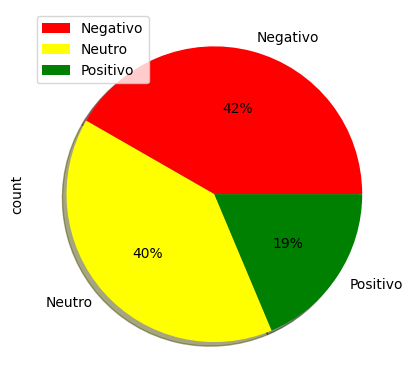

In [13]:
color=['red','yellow', 'green']
explode=[0, 0, 0]
mylabels = ['Negativo', 'Neutro', 'Positivo']

df['y'].value_counts().plot(kind='pie',  autopct='%1.0f%%', labels=mylabels, explode=explode,colors=color, shadow=True)
plt.legend()

# Funções configuradas para o Pré-Processamento de "X"

Função própria para Remover caracteres especiais (acentos e afins)

In [14]:
# Remover caracteres especiais (acentos e afins)

def remove_special_chars(input_text):
    input_text = re.sub(u'[áãâà]', 'a', input_text)
    input_text = re.sub(u'[éèê]', 'e', input_text)
    input_text = re.sub(u'[íì]', 'i', input_text)
    input_text = re.sub(u'[óõôò]', 'o', input_text)
    input_text = re.sub(u'[úùü]', 'u', input_text)
    input_text = re.sub(u'[ç]', 'c', input_text)
    return input_text

Função própria para Remover dígitos

In [15]:
def remove_digits(input_text):
    import re
    return re.sub('\d+', '', input_text)

Função própria para Definir Lista de StopWords

In [16]:
def define_list_stopwords(lg):

  try:
    stopwords_list = stopwords.words(lg)
  except:
    nltk.download('stopwords')
    stopwords_list = stopwords.words(lg)

  return stopwords_list

Função própria para Remover Stopwords

In [17]:
def remove_stopwords(input_text):
    stopwords_list = define_list_stopwords('portuguese')
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1]
    return " ".join(clean_words)

Função própria para Radicalização (Stemming)

In [18]:
def stemming(input_text):
    porter = PorterStemmer()
    words = input_text.split()
    stemmed_words = [porter.stem(word) for word in words]
    return " ".join(stemmed_words)

Função própria para remover *URL*

In [19]:
def removeURLs(input_text):
  URLless_string = re.sub(r'https?:\/\/\s*t\.\s*co\/\S+|www\.\S+', '', input_text, flags=re.IGNORECASE)
  return (URLless_string)

In [20]:
def removeMencoes(input_text):

  URLless_string = re.sub(r"@([A-Za-z0-9_]{1,15})", "", str(input_text))
  return (URLless_string)

# Pré-Processamento de "X"

In [21]:
### Função para o pipeline completo do Pré-processamento de "X"

def pipeline_preprocessamento(dfParaProcessar):


  # Remover dígitos
  dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: remove_digits(x))

  # Remover URLs
  dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: removeURLs(x))

  # Remover menções
  dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: removeMencoes(x))

  return dfParaProcessar

In [22]:
df = pipeline_preprocessamento(df)
df

,x,y
0,pq ngm chuta os fios do moodle do ifg,0
1,(ifg não chega nem aos pés),0
2,aí ai gente a ester é artista!!!! mais uma a...,2
3,ho sr.minha filha e funcionária do ifg. grati...,2
4,"que inferno, te odeio ifg",0
...,...,...
1961,"não amg, estudo no instituto federal",1
1962,oi amg eu faço curso técnico de procesos foto...,1
1963,instituto federal do cafe melita,1
1964,alunos do instituto federal que reconhecem alm...,1


In [23]:
df_teste = pipeline_preprocessamento(df_teste)
df_teste

,x
0,Especialização gratuita em Docência do IFMS ab...
1,Não ironicamente eu gosto mais do ifb do que q...
2,saudade almoço do ifb
3,Quem bora pra festa do IFB?
4,hj vi a saga de diários de vampiro inteira na ...
...,...
75797,agora vim do ifma em uma pop com pessoas e m...
75798,#Repost No dia / o em parceria com a coord...
75799,Às vezes bate uma saudade do ifal tlgd
75800,eu e julia ouvindo chappell roan ao lado do ma...


In [24]:
#df_teste = pipeline_preprocessamento(df_teste)
    #valdata = DataLoader(dataval, batch_size=batch_size_trnf_FT, shuffle=False)


# Funções para definir a configuração do TRANSFORMER:

In [25]:
### FUNÇÃO COM AS PRINCIPAIS CONFIGURAÇÕES DO TRANSFORMER ESCOLHIDO PARA O EXPERIMENTO

def configTRNF(trf_escolhido, nclasses, dropout):

  ### configuração
  configuration = AutoConfig.from_pretrained(trf_escolhido, output_hidden_states=True )
  configuration.hidden_dropout_prob = dropout
  configuration.num_labels=nclasses
  configuration.output_hidden_state=True

  ### tokenizador
  tokenizer = AutoTokenizer.from_pretrained(trf_escolhido, do_lower_case=False)

  modelTRNF = AutoModelForSequenceClassification.from_pretrained(trf_escolhido, config=configuration )
  modelTRNF.to(device) 

  return modelTRNF, tokenizer


# REALIZAR O EXPERIMENTO COM FINE TUNING:

# Função para medir o desempenho do Modelo TRF

In [26]:
def evaluateTRF(model, tokenizer, testdata):
  model.eval()        #chaveia o modelo para modo avaliação (necessário, algumas camadas (dropout, normalization) funcionam diferente em modo avaliação)
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata): #para cada batch de exemplos de teste
    texts, labels = inp['X'], inp['y']  #obtem o batch

    # classifying

    #inputs = tokenizer(texts, return_tensors=lg_trf, padding=True, truncation=True, max_length=max_length_trnf_FT)
    inputs = tokenizer(texts, return_tensors=lg_trf,  padding='max_length', truncation=True, max_length=max_length_trnf_FT) #tokeniza o exemplo
    inputs = inputs.to(device)  ### USAR SE NÃO FOR USAR O ACCELARATOR


    output = model(**inputs) #passa o exemplo tokenizado para o modelo e obtém a resposta.

    pred_labels = torch.argmax(output.logits, 1) #Dentre as possíveis classes, pega a que deu a maior saída.

    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())

  f1 = f1_score(y_real, y_pred, average='macro')
  acc = accuracy_score(y_real, y_pred)

  return f1, acc

# Funções para realização do Treinamento do Modelo neste experimento:

In [27]:
def treinarModeloTRF(model, tokenizer, xTreinoParaProcessar, yTreinoParaProcessar, lrate, nepochs, early_stop):

    print("#### Realizando o Treinamento .....")
    print("  ")

    ### do total do dataset, separar uma parte para dados de validação
    xtrain,xval,ytrain,yval=train_test_split(xTreinoParaProcessar,yTreinoParaProcessar,test_size=0.20,random_state=0, stratify=yTreinoParaProcessar)

    #Organizando os dados para loader no Pytorch
    datatrain = [{ 'X': xtrain, 'y': ytrain } for (xtrain, ytrain) in zip( xtrain, ytrain)] ### Organizando dados de treino
    dataval = [{ 'X': xval, 'y': yval } for (xval, yval) in zip( xval, yval)] ### Organizando dados de validação

    #### Fazendo do DataLoader exigido pelo PyTorch
    traindata = DataLoader(datatrain, batch_size=batch_size_trnf_FT, shuffle=True) ### Fazendo o DataLoader dos dados de treinamento
    valdata = DataLoader(dataval, batch_size=batch_size_trnf_FT, shuffle=False) ### Fazendo o DataLoader dos dados de validação

    optimizer = optim.AdamW(model.parameters(), lr=lrate)

    ### fit
    max_f1, repeat = 0, 0
    best_model = model

    train_f1_macro = []
    train_median_losses = []
    val_f1_macro = []

    for epoch in range(nepochs):

        #model, optimizer, traindata, valdata = accelerator.prepare(model,optimizer,traindata, valdata) #acelerar com GPU

        model.train()  ### prepara para o treinamento
        #f1, acc = evaluateTRF(model, tokenizer, valdata) #para cada epoca, apresenta os resultados do modelo atual com o conjunto de teste

        train_losses = []

        for batch_idx, inp in enumerate(traindata):
            texts, labels = inp['X'], inp['y']


            # classifying
            #inputs = tokenizer(texts, return_tensors=lg_trf, padding=True, truncation=True, max_length=max_length_trnf_FT)
            inputs = tokenizer(texts, return_tensors=lg_trf,  padding='max_length', truncation=True, max_length=max_length_trnf_FT) #tokeniza o exemplo
            inputs = inputs.to(device)  ### USAR SE NÃO FOR USAR O ACCELARATOR

            output = model(**inputs, labels=labels.to(device))

            # Calculate loss
            loss = output.loss
            train_losses.append(float(loss))


            # Backpropagation
            loss.backward() #computa os gradientes  ### USAR SE NÃO FOR USAR O ACCELARATOR
            #accelerator.backward(loss)

            optimizer.step() #Atualiza os parametros
            optimizer.zero_grad() #zera os gradientes para proxima iteracao

        f1_train, acc_train = evaluateTRF(model, tokenizer, traindata)
        train_f1_macro.append(f1_train)

        f1, acc = evaluateTRF(model, tokenizer, valdata)
        val_f1_macro.append(f1)

        train_median_losses.append(round(sum(train_losses) / len(train_losses), 5))

        print('Train Epoch: ',epoch+1,"/",nepochsFT_trnf_FT, '---> Loss (Train): ', round(sum(train_losses) / len(train_losses), 5),'Macro-F1 (Val): ', f1, 'Accuracy (Val): ', acc)

        if f1 > max_f1:   ### verifica se nessa época o modelo melhorou
          ##model.save_pretrained(os.path.join(write_path, 'model'))   ### salva o modelo na máquina
          max_f1 = f1
          repeat = 0
          best_model = copy.deepcopy(model)
          ###print('Saving best model...')
        else:
          repeat += 1

        if repeat == early_stop:  ### verifica se pode acionar o early stop após a quantidade de épocas sem melhorar
          break

    history_train = {'loss': train_median_losses,
                      'f1_macro': train_f1_macro,
                      'val_f1_macro': val_f1_macro}
    f1_best, acc_best = evaluateTRF(best_model, tokenizer, valdata)  ### apenas faz uma última avaliação com o melhor modelo
    print('Desempenho na Validação: ' + ' Macro-F1 (Val): ', f1_best, 'Accuracy (Val): ', acc_best)
    print("  ")
    return best_model, f1_best, acc_best, history_train

# Funções para fazer predições utilizando o modelo:

In [28]:
def fazerPredicaoTRF(xParaProcessar, model, tokenizer):

    #Organizando os dados para loader no Pytorch
    datatest = [{ 'X': xParaProcessar } for xParaProcessar in xParaProcessar]

    testdata = DataLoader(datatest, batch_size=batch_size_trnf_FT, shuffle=False) ### Fazendo o DataLoader dos dados


    y_pred = []

    for batch_idx, inp in enumerate(testdata):
        texts = inp['X']

        inputs = tokenizer(texts, return_tensors=lg_trf,  padding='max_length', truncation=True, max_length=max_length_trnf_FT) #tokeniza o exemplo
        inputs = inputs.to(device)  ### passa o tensor para GPU

        output = model(**inputs) #passa o exemplo tokenizado para o modelo e obtém a resposta.

        pred_labels = torch.argmax(output.logits, 1) #Dentre as possíveis classes, pega a que deu a maior saída.

        y_pred.extend(pred_labels.tolist())



    return y_pred



# Funções para realização do Teste do Modelo neste experimento:

In [29]:
def testarModeloTRF(xTesteParaProcessar, yTesteParaProcessar, model, tokenizer):

    print("#### Realizando o Teste .....")
    print("  ")

    #Organizando os dados para loader no Pytorch
    datatest = [{ 'X': xTesteParaProcessar, 'y': yTesteParaProcessar } for (xTesteParaProcessar, yTesteParaProcessar) in zip( xTesteParaProcessar, yTesteParaProcessar)]

    #### Fazendo do DataLoader exigido pelo PyTorch
    testdata = DataLoader(datatest, batch_size=batch_size_trnf_FT, shuffle=False)

    # Mostrando o desempenho do modelo no dataset de teste
    f1, acc = evaluateTRF(model, tokenizer, testdata)
    print('Desempenho no Teste: ' + ' Macro-F1 (Teste): ', f1, 'Accuracy (Teste): ', acc)
    print("  ")

    return f1, acc

# Funções para preparar um DataFrame com os resultados de cada experimento

In [30]:
def retornarDfResultados():
  dfResultadosTRF = pd.DataFrame(columns=[
      'Exp', 'Learning Rate', 'Dropout', 'Acc-Val', 'f1-Val (Macro)', 'Acc-Test', 'f1-Test (Macro)', 'history'
      ])

  return dfResultadosTRF

In [31]:
def atualizarResultadosTRF(dfResultados, ln, dpout, acc_val, f1_val, acc_test, f1_test, hist):

    idx = dfResultados.loc[(dfResultados['Learning Rate'] == ln) & (dfResultados['Dropout'] == dpout)].index

    if(idx.empty):
      acc_val_k = np.array([acc_val])
      f1_val_k = np.array([f1_val])
      acc_test_k = np.array([acc_test])
      f1_test_k = np.array([f1_test])
      hist_k = [hist]

      res = {'Exp': 1,'Learning Rate': ln, 'Dropout': dpout, 'Acc-Val': acc_val_k, 'f1-Val (Macro)': f1_val_k, 'Acc-Test': acc_test_k, 'f1-Test (Macro)': f1_test_k, 'history': hist_k}
      dfResultados.loc[len(dfResultados)] = res
    else:
      acc_val_k = np.append(dfResultados.at[idx[0], 'Acc-Val'],acc_val)
      dfResultados.at[idx[0],'Acc-Val']=acc_val_k
      f1_val_k = np.append(dfResultados.at[idx[0], 'f1-Val (Macro)'],f1_val)
      dfResultados.at[idx[0],'f1-Val (Macro)']=f1_val_k

      acc_test_k = np.append(dfResultados.at[idx[0], 'Acc-Test'],acc_test)
      dfResultados.at[idx[0],'Acc-Test']=acc_test_k
      f1_test_k = np.append(dfResultados.at[idx[0], 'f1-Test (Macro)'],f1_test)
      dfResultados.at[idx[0],'f1-Test (Macro)']=f1_test_k

      hist_k = np.append(dfResultados.at[idx[0], 'history'],hist)
      dfResultados.at[idx[0],'history']=hist_k

    return dfResultados

In [32]:
def consolidarResultadosTRF(dfResultados):

    # Média e Desvio padrão da Acurácia no processamento da Validação em todos os K-Folds
    dfResultados["Média-Acc-Val"] = [col.mean() for col in dfResultados['Acc-Val']]
    dfResultados["Desvio-Acc-Val"] = [col.std() for col in dfResultados['Acc-Val']]

    # Média e Desvio padrão da F1-Macro no processamento da Validação em todos os K-Folds
    dfResultados["Média-f1-Val (Macro)"] = [col.mean() for col in dfResultados['f1-Val (Macro)']]
    dfResultados["Desvio-f1-Val (Macro)"] = [col.std() for col in dfResultados['f1-Val (Macro)']]

    # Média e Desvio padrão da Acurácia no processamento do Teste em todos os K-Folds
    dfResultados["Média-Acc-Test"] = [col.mean() for col in dfResultados['Acc-Test']]
    dfResultados["Desvio-Acc-Test"] = [col.std() for col in dfResultados['Acc-Test']]

    # Média e Desvio padrão da F1-Macro no processamento do Teste em todos os K-Folds
    dfResultados["Média-f1-Test (Macro)"] = [col.mean() for col in dfResultados['f1-Test (Macro)']]
    dfResultados["Desvio-f1-Test (Macro)"] = [col.std() for col in dfResultados['f1-Test (Macro)']]

    dfResultados['Exp'] = dfResultados.index + 1

    return dfResultados

# Treinando toda a base

In [33]:
device = torch.device("cuda:0")

In [34]:
ln = 0.00005
dpout = 0.1
nepoch_final = 1
early_stop_final = early_stop_trnf_FT

In [35]:
model_trf, tk_trf = configTRNF(trf_escolhido, nclasses, dpout)

2025-02-25 20:08:57.449445: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 20:08:57.449508: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 20:08:57.449553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 20:08:57.461082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-25 20:08:58.594696: W tensorflow/compiler/

In [36]:
torch.cuda.empty_cache()

import gc
gc.collect()

7

In [37]:
def medirResultados(yPreditoParaProcessar, yRealParaProcessar, macros, micros):
    print(f"Precisão: {precision_score(yRealParaProcessar, yPreditoParaProcessar, average='micro')} ")
    print(f"Revocação: {recall_score(yRealParaProcessar, yPreditoParaProcessar, average='micro')} ")
    print(f"f1 Score (Micro): {f1_score(yRealParaProcessar, yPreditoParaProcessar, average='micro')} ")
    micros.append(f1_score(yRealParaProcessar, yPreditoParaProcessar, average='micro'))
    print(f"f1 Score (Macro): {f1_score(yRealParaProcessar, yPreditoParaProcessar, average='macro')} ")
    macros.append(f1_score(yRealParaProcessar, yPreditoParaProcessar, average='macro'))


In [38]:
from sklearn.model_selection import KFold

macros = []
micros = []

kf = KFold(n_splits=numKfolds, shuffle=True, random_state=0)

for train_index, test_index in kf.split(df["x"]):
    xTreino, xTeste = df["x"].iloc[train_index], df["x"].iloc[test_index]
    yRealTreino, yRealTeste = df["y"].iloc[train_index], df["y"].iloc[test_index]

    model, f1_val, acc_val, hist = treinarModeloTRF(model_trf, tk_trf, xTreino, yRealTreino, ln, nepoch_final, early_stop_final)

    torch.cuda.empty_cache()
    gc.collect()

    ypredito = fazerPredicaoTRF(xTeste, model, tk_trf)

    medirResultados(ypredito, yRealTeste, macros, micros)


macro_f1 = np.mean(micros)
micro_f1 = np.mean(macros)
std_f1 = np.std(macros)

print('\n\n')
print(f'Média da Macro-F1: {macro_f1:.6f}')
print(f'Média da Micro-F1: {micro_f1:.6f}')
print(f'Desvio padrão da Macro-F1: {std_f1:.6f}')


#### Realizando o Treinamento .....
  
Train Epoch:  1 / 1 ---> Loss (Train):  0.81271 Macro-F1 (Val):  0.7239726598316246 Accuracy (Val):  0.7301587301587301
Desempenho na Validação:  Macro-F1 (Val):  0.7239726598316246 Accuracy (Val):  0.7301587301587301
  
Precisão: 0.7030456852791879 
Revocação: 0.7030456852791879 
f1 Score (Micro): 0.7030456852791879 
f1 Score (Macro): 0.6984717134717137 
#### Realizando o Treinamento .....
  
Train Epoch:  1 / 1 ---> Loss (Train):  0.51739 Macro-F1 (Val):  0.798942160703448 Accuracy (Val):  0.8126984126984127
Desempenho na Validação:  Macro-F1 (Val):  0.798942160703448 Accuracy (Val):  0.8126984126984127
  
Precisão: 0.8269720101781171 
Revocação: 0.8269720101781171 
f1 Score (Micro): 0.8269720101781171 
f1 Score (Macro): 0.8201300665043388 
#### Realizando o Treinamento .....
  
Train Epoch:  1 / 1 ---> Loss (Train):  0.35249 Macro-F1 (Val):  0.8785793970321034 Accuracy (Val):  0.8888888888888888
Desempenho na Validação:  Macro-F1 (Val):  0.8785

In [39]:
"""# Predição na Base de Teste"""

# Fazer a predição na base de teste
y_predito_teste = fazerPredicaoTRF(df_teste['x'], model_trf, tk_trf)

# Adicionar as predições ao DataFrame de teste
df_teste['y_predito'] = y_predito_teste

# Salvar o DataFrame com as predições
df_teste.to_csv('./dataset_if_polarity.csv', index=False)

print("Predições salvas em 'dataset_if_polarity.csv'")

Predições salvas em 'dataset_if_polarity.csv'
